In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import openpathsampling as paths
import numpy as np

from openpathsampling.engines.openmm.tools import ops_load_trajectory

# Example: Analyzing flux out of Watson-Crick DNA

This example comes from a project studying the transition between the Watson-Crick and Hoogsteen base pairing motifs in DNA (Vreede, Bolhuis, Swenson. In prep.) To calculate the rate of the transtion, we used TIS, which requires the calculation of the flux out of the state and through an innermost interface. This notebook shows how to calculate that flux from an existing MD calculation, and how to select the location for the innermost interface.

In this particular case, we had already begun path sampling, and so we didn't want to change the definition of our states. This makes it a bit more challenging to find a good interface, but, as shown below, the problem can still be solved.

The calculations below focus on the `run0.xtc` file, although they could easily be extended to include the other runs as well. At the end, we will calculate things using all the runs.

The data for this can be downloaded from ???

In [2]:
%%time
files = ['run0.xtc', 'run1.xtc', 'run2.xtc', 'run3.xtc', 'run4.xtc']
# load the data
runs = [ops_load_trajectory(f, top='dna.gro') for f in files]

CPU times: user 1min 29s, sys: 1.53 s, total: 1min 31s
Wall time: 1min 35s


We'll start by looking in some details at `run0.xtc`

In [3]:
run0 = runs[0]

In [4]:
# use an mdtraj-style topology for its magic features
topology = run0.topology.mdtraj

In [5]:
print topology.atom(275), topology.atom(494)
print topology.atom(275), topology.atom(488)
print topology.atom(274), topology.atom(491)

DT9-N3 DA4-N1
DT9-N3 DA4-N7
DT9-O4 DA4-N6


That was just a little check that we're looking at the right atoms. The MDTraj `Topology` makes that really easy.

### Define the CVs, states, and interfaces

We'll use these CVs for the entire simulation. `d_bp` measures a distance repesenting a hydrogen bond common to both the WC and HG states. `d_WC` is a distance that represents a hydrogen bond formed in the WC state (but which is not formed in HG), and `d_HG` is a distance for a hydrogen bond formed in the HG state (which not in WC). The specific atoms involved are shown in the previous section, using the topology.

In [6]:
# first we define the CVs that we'll be using
d_WC = paths.MDTrajFunctionCV("d_WC", md.compute_distances, run0.topology, atom_pairs=[[275, 494]])
d_HG = paths.MDTrajFunctionCV("d_HG", md.compute_distances, run0.topology, atom_pairs=[[275, 488]])
d_bp = paths.MDTrajFunctionCV("d_bp", md.compute_distances, run0.topology, atom_pairs=[[491, 274]])

To combine both the WC and HG bonds, we use the `atan2` function. Note that, if you want to make a CV that is composed of other CVs, you can do this by using the other CVs as input variables.

In [7]:
def atan2_cv_fcn(snapshot, d_WC, d_HG):
    import math
    wc = d_WC(snapshot)
    hg = d_HG(snapshot)
    return math.atan2(wc, hg)

atan2_cv = paths.CoordinateFunctionCV("atan2", atan2_cv_fcn, d_WC=d_WC, d_HG=d_HG)

Next we define our WC and HG states.

In [8]:
# the states are a combination of volumes defined by these CVs
state_WC = (paths.CVDefinedVolume(d_WC, lambda_min=0.0, lambda_max=0.35) &
            paths.CVDefinedVolume(d_bp, lambda_min=0.0, lambda_max=0.35)).named("WC")

state_HG = (paths.CVDefinedVolume(d_HG, lambda_min=0.0, lambda_max=0.35) &
            paths.CVDefinedVolume(d_bp, lambda_min=0.0, lambda_max=0.35)).named("HG")

Now let's plot these CVs. Since this trajectory is of the WC state, the `d_WC` should be small, and `d_HG` should be large.

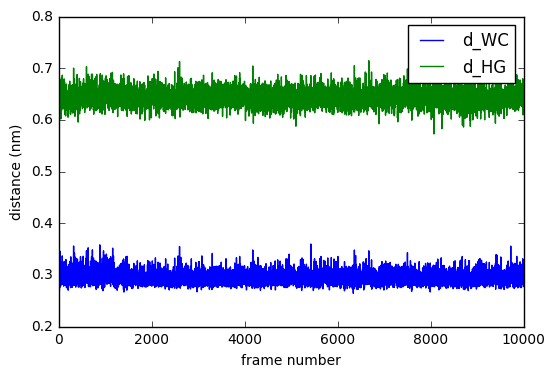

In [9]:
(wc_line,) = plt.plot(d_WC(run0), label="d_WC")
(hg_line,) = plt.plot(d_HG(run0), label="d_HG")
plt.xlabel('frame number')
plt.ylabel('distance (nm)')
plt.legend(handles=[wc_line, hg_line]);

Okay, that looks good. Now we'll plot the atan2 values:

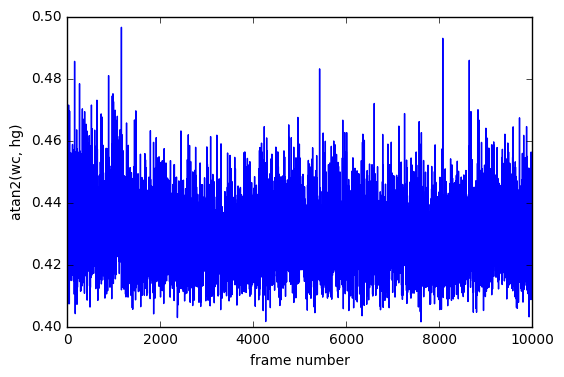

In [10]:
plt.plot(atan2_cv(run0))
plt.xlabel('frame number')
plt.ylabel('atan2(wc, hg)');

Originally, the original innermost interface was at 0.5: it doesn't look like this trajectory ever crosses that interface. To be very sure, we'll check the interface itself.

In [11]:
# Now we define the interfaces. First we define the contribution from the atan2 part:
# (for now I only include the innermost interface, since that's the one I care about)

atan2_vals = paths.VolumeInterfaceSet(atan2_cv, 0.0, [0.5])

# The actual interface volumes are the atan2-based volumes combined with state
# (to be outside the interface you must also be outside the state!)
interfaces = [iface | state_WC for iface in atan2_vals]

### Analyze the frames based on these states/interfaces

Now we count how many frames are outside the interface:

In [12]:
out_interface_frames = [frame for frame in run0 if not interfaces[0](frame)]
print len(out_interface_frames)

0


Okay, 0 frames outside the interface. That's not good. Just for fun, let's do the same and see how many frames are outside the state:

In [13]:
out_state_frames = [frame for frame in run0 if not state_WC(frame)]
print len(out_state_frames)

257


Well, 257/10000 is reasonable, but still rather small, actually. But we can work with that.

One last thing: let's see what the values of atan2 are for those frames. We need those frames to also be outside our interface.

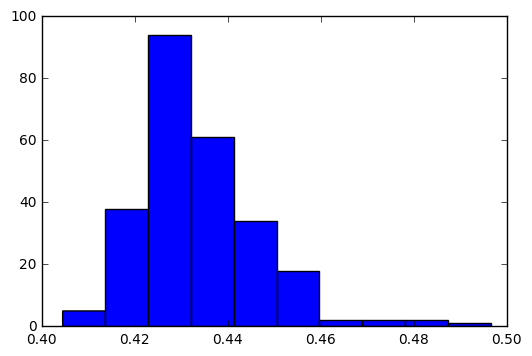

In [14]:
plt.hist(atan2_cv(out_state_frames));

So some frames are outside the state with atan2 a bit over 0.4. Based on the histogram, it looks to me like we should put an interface around 0.43 or so, to make sure we have enough frames outside the interface and the state.

Let's compare this distribution with the atan2 distribution for the whole trajectory:

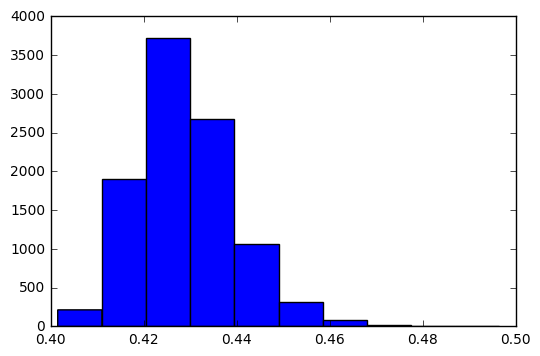

In [15]:
plt.hist(atan2_cv(run0));

Note that the frames that are outside the state have the (about) same atan2 distribution as the whole trajectory, which means that (in the vicinity of the WC state) there's no correlation between atan2 and being outside the state.

We can still define an interface around 0.43, because the trajectory will only be outside the interface if it is also outside the state, but this does mean that some frames *inside* the state will have a larger order parameter than frames *outside* the state, which seems odd from an intuitive perspective.

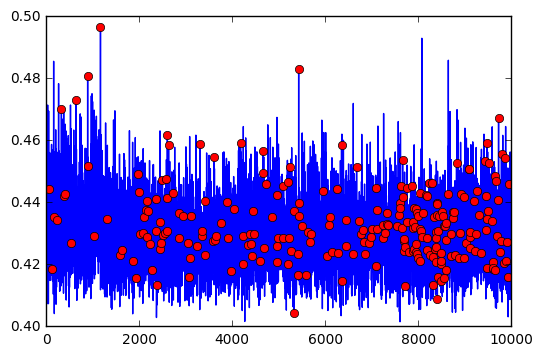

In [16]:
plt.plot(atan2_cv(run0))
input_index = [run0.index(s) for s in out_state_frames]
plt.plot(input_index, atan2_cv(run0[input_index]), 'ro');

The picture above shows the issue in another way: the blue shows `atan2` for *all* frames. The red dots are the frames that are outside the state. The correlation with `atan2` is not very strong when we're near the Watson-Crick state. You would much rather see something where all the red dots are clustered near the top of the blue.

The best thing to do here would be to change the states to have more strict boundaries. However, we had already started sampling at this point, so the state definitions were fixed (whereas new interfaces can easily be added to a simple TIS simulation).

Now we'll do some flux analysis for this transition:

In [17]:
wc_hg = paths.TISTransition(stateA=state_WC, 
                            stateB=state_HG, 
                            interfaces=interfaces, 
                            orderparameter=atan2_cv)

In [18]:
analyzer = paths.TrajectoryTransitionAnalysis(wc_hg, dt=2.0) # time in picoseconds

The next cells will create a couple interfaces (you are inside the interface if you are inside the value for `atan2` ***or*** if you are inside the state) and then figure out how many flux events there are through each of those interfaces. The `analyze_flux` method returns a dictionary with keys `'in` and `'out'`, corresponding to the parts of each flux that are in and out of the interface, respectively. We'll focus on the times that the trajectory is out of the interface.

In [19]:
%%time
iface_43 = state_WC | paths.CVDefinedVolume(atan2_cv, lambda_min=0.0, lambda_max=0.43)
out_43 = analyzer.analyze_flux(trajectories=run0,
                               state=state_WC,
                               interface=iface_43)['out']
print len(out_43)

137
CPU times: user 27.7 s, sys: 361 ms, total: 28.1 s
Wall time: 28.7 s


In [20]:
iface_45 = state_WC | paths.CVDefinedVolume(atan2_cv, lambda_min=0.0, lambda_max=0.45)
out_45 = analyzer.analyze_flux(trajectories=run0,
                               state=state_WC,
                               interface=iface_45)['out']
print len(out_45)

25


So if we set the interface at `atan2=0.43`, and at `0.45` we get 25. The next question to ask is *how long* do each of these flux events last. In the next cells, I'll plot a histogram of that for the interface at 0.43.

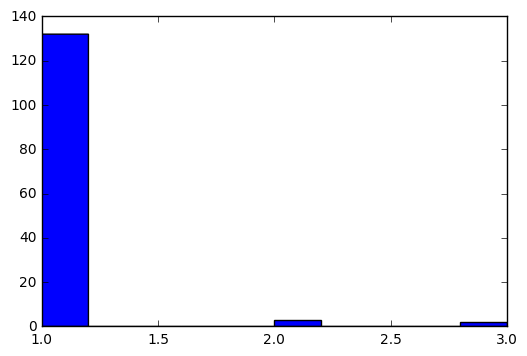

In [21]:
plt.hist([len(traj) for traj in out_43]);

All of these are dominated by having a single frame outside the interface; however, the ones with interfaces closer in are better (only 0.43 is shown).

An even better thing to look at would be same kind of analysis, but for the whole trajectory that would be sampled by TIS. (There could be frames outside the state, but not outside the interface, that are part of this trajectory.) This basically amounts to finding all the possible shooting points that each segment would have.

The ensemble defined below requires that all frame from the subtrajectories it finds be outside the state and at least one be outside the interface. This gives us the segments that can be used as shooting points.

Segments: 137
Longer than 1 frame: 8


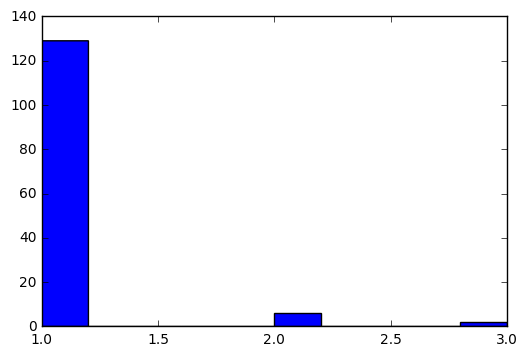

In [22]:
all_shooting_ensemble_43 = paths.AllOutXEnsemble(state_WC) & paths.PartOutXEnsemble(iface_43)
segments_43 = all_shooting_ensemble_43.split(run0)
plt.hist([len(s) for s in segments_43])
print "Segments:", len(segments_43)
print "Longer than 1 frame:", len([s for s in segments_43 if len(s) > 1])

It is just as easy to calculate the flux

In [23]:
flux_dict_43 = analyzer.analyze_flux(trajectories=runs,
                                     state=state_WC,
                                     interface=iface_43)

all_shooting_43 = [all_shooting_ensemble_43.split(run) for run in runs]
all_shooting_43 = sum(all_shooting_43, [])

In [24]:
print len(flux_dict_43['out'])

567


In [25]:
print len(flux_dict_43['in'])

562


In [26]:
print "Segments:", len(all_shooting_43)
print "Longer than 1 frame:", len([s for s in all_shooting_43 if len(s) > 1])

Segments: 569
Longer than 1 frame: 33


Finally, we can directly calculate the flux. Since the `analyzer` knows that the time between frames is 0.2 ps, the result is in units of events/picosecond. We could do this for just one run in the same way, but we'll go ahead and calculate it for all of them:

In [28]:
print analyzer.flux(trajectories=runs,
                    state=state_WC,
                    interface=iface_43)

0.00572665248916
